In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [9]:
pd.set_option('display.max_columns', 25)
df = pd.read_csv('../dev/fraudTrain.csv', index_col=0)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [11]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_dow'] = df['trans_date_trans_time'].dt.dayofweek
df.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_dow
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1


In [12]:
numerical_features = ['amt'] 
categorical_features = [
    'category', 'merchant', 'city', 'state',
    'job', 'trans_hour', 'trans_dow'
    ]
target = 'is_fraud'  

df = df[numerical_features + categorical_features + [target]]

# get dummies for each cat variable
for cat in categorical_features:
    df = pd.concat([df, pd.get_dummies(df[cat], prefix=cat, drop_first=True)], axis=1)
    df.drop(cat, axis=1, inplace=True)


## Sampling

In [13]:
df_majority = df[df.is_fraud==0].copy()
df_minority = df[df.is_fraud==1].copy()
df_maj_dowsampled = resample(df_majority, n_samples=len(df_minority), replace=False, random_state=42)
df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

df = df_downsampled.reset_index()

df.shape

(15012, 2173)

## Prepare data for models

In [98]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LogisticRegression

Best parameters for LR:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1496
           1       0.89      0.91      0.90      1507

    accuracy                           0.90      3003
   macro avg       0.90      0.90      0.90      3003
weighted avg       0.90      0.90      0.90      3003



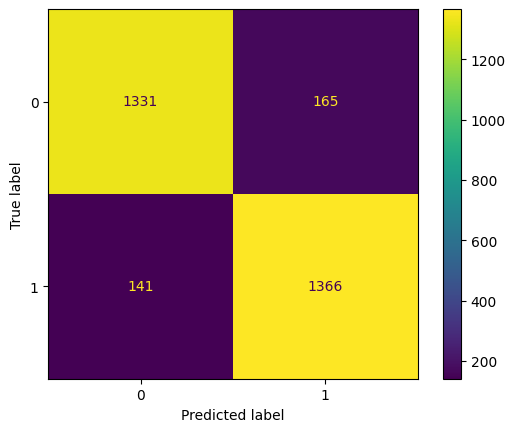

In [90]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga']
}

grid_search_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

grid_search_lr.fit(X_train, y_train)

print("Best parameters for LR: ", grid_search_lr.best_params_)

best_lr = grid_search_lr.best_estimator_

y_pred = best_lr.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lr.classes_)
disp.plot()
plt.show()


## CatBoost

Best params for CatBoost:  {'depth': 6, 'iterations': 300, 'learning_rate': 0.3}
CatBoost Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1496
           1       0.98      0.96      0.97      1507

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003



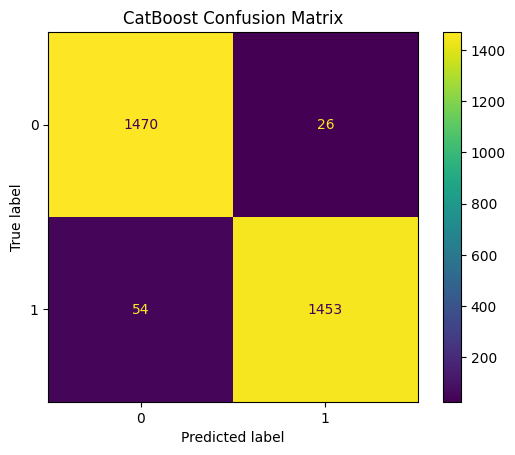

In [99]:
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search_catboost = GridSearchCV(CatBoostClassifier(verbose=0), param_grid_catboost, cv=5, scoring='recall')

grid_search_catboost.fit(X_train, y_train)

print('Best params for CatBoost: ', grid_search_catboost.best_params_)

best_catboost = grid_search_catboost.best_estimator_
y_pred_catboost = best_catboost.predict(X_test)

print("CatBoost Classification Report")
print(classification_report(y_test, y_pred_catboost))

cm_catboost = confusion_matrix(y_test, y_pred_catboost)
disp_catboost = ConfusionMatrixDisplay(confusion_matrix=cm_catboost, display_labels=best_catboost.classes_)
disp_catboost.plot()
plt.title("CatBoost Confusion Matrix")
plt.show()

## XGBoost

Best params for XGBoost:  {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.9}
XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1496
           1       0.98      0.97      0.97      1507

    accuracy                           0.97      3003
   macro avg       0.97      0.97      0.97      3003
weighted avg       0.97      0.97      0.97      3003



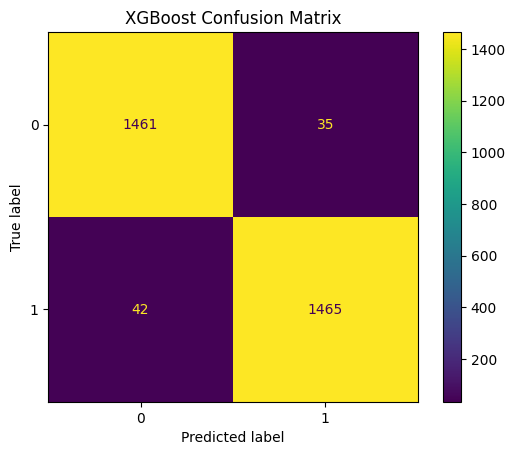

In [94]:
param_grid_xgboost = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search_xgboost = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgboost, cv=5, scoring='accuracy')

grid_search_xgboost.fit(X_train, y_train)

print('Best params for XGBoost: ', grid_search_xgboost.best_params_)

best_xgboost = grid_search_xgboost.best_estimator_
y_pred_xgboost = best_xgboost.predict(X_test)

print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgboost))

cm_xgboost = confusion_matrix(y_test, y_pred_xgboost)
disp_xgboost = ConfusionMatrixDisplay(confusion_matrix=cm_xgboost, display_labels=best_xgboost.classes_)
disp_xgboost.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

## RandomForest

Best params for RandomForest:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1496
           1       0.98      0.94      0.96      1507

    accuracy                           0.96      3003
   macro avg       0.96      0.96      0.96      3003
weighted avg       0.96      0.96      0.96      3003



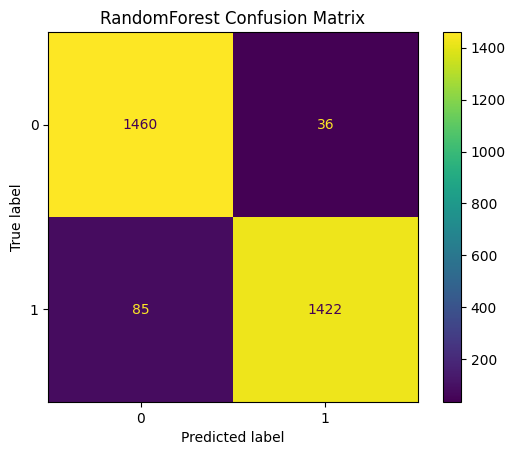

In [95]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

print('Best params for RandomForest: ', grid_search_rf.best_params_)

best_random_forest = grid_search_rf.best_estimator_
y_pred_random_forest = best_random_forest.predict(X_test)

print("RandomForest Classification Report")
print(classification_report(y_test, y_pred_random_forest))

cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)
disp_random_forest = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest, display_labels=best_random_forest.classes_)
disp_random_forest.plot()
plt.title("RandomForest Confusion Matrix")
plt.show()

## LGBMClassifier

Best params for LightGBM:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 70}
LightGBM Classification Report
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1496
           1       0.90      0.87      0.88      1507

    accuracy                           0.89      3003
   macro avg       0.89      0.89      0.89      3003
weighted avg       0.89      0.89      0.89      3003



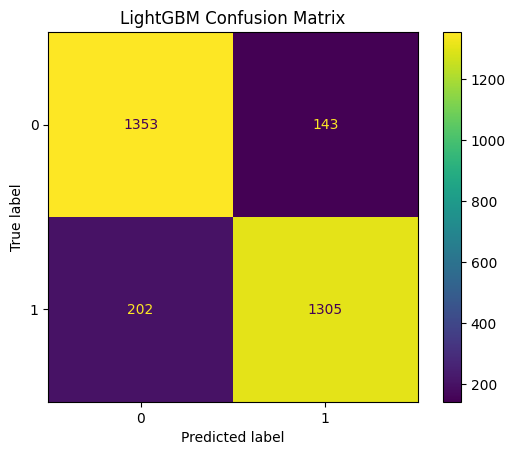

In [96]:
X = df.loc[:, 'amt']
y = df.loc[:, 'is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid_lgbm = {
    'num_leaves': [31, 50, 70],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

grid_search_lgbm = GridSearchCV(LGBMClassifier(), param_grid_lgbm, cv=5, scoring='accuracy')

X_train_reshaped = np.array(X_train).reshape(-1, 1)
X_test_reshaped = np.array(X_test).reshape(-1, 1)

grid_search_lgbm.fit(X_train_reshaped, y_train)

print('Best params for LightGBM: ', grid_search_lgbm.best_params_)

best_lgbm = grid_search_lgbm.best_estimator_

y_pred = best_lgbm.predict(X_test_reshaped)

print("LightGBM Classification Report")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lgbm.classes_)
disp.plot()
plt.title("LightGBM Confusion Matrix")
plt.show()